In [ ]:
# 第14章 自然语言处理：预训练

In [ ]:
import math
import os
import random
import torch
from d2l import torch as d2l

## 14.1 词嵌入（word2vec）

### 练习14.1.1

计算每个梯度的计算复杂度是多少？如果词表很大，会有什么问题呢？

**解答：**

&emsp;&emsp;梯度的计算需要求函数在每个自变量方向上的偏导数，因此梯度的计算复杂度取决于自变量的数量。在书中，下列公式给出了计算单个中心词向量：

$$
{u_o}-{\sum_{j \in V}P({W_j}|{W_c}){u_j}}
$$

&emsp;&emsp;由上述公式可知，单计算一个中心词向量的梯度就需要计算以该词为中心词，所有词的条件概率。故其复杂度约为`len(V)^2`，如果词表太大，则计算量会相应呈平方增加，会使梯度求解的复杂度过大，不易更新权重;且词表过大，也会相应占据更大的存储空间，使训练更难进行。


### 练习14.1.2

英语中的一些固定短语由多个单词组成，例如“new york”。如何训练它们的词向量？提示:查看word2vec论文的第四节。

**解答：**

&emsp;&emsp;在 word2vec 论文的第四节中，提到了两种训练固定短语词向量的方法：

&emsp;&emsp;1.使用连字符（hyphen）将多个单词组合成一个词，例如 "new-york"。这样可以让算法将多个单词视为一个词来训练，从而学习到它们的词向量。但是这种方法对于较长的短语不太适用，因为可能会出现组合后的词太长的情况。

&emsp;&emsp;2.使用特殊的标记将多个单词标记为一个短语，例如 "< NewYork >"。这种方法可以将多个单词组合成一个符号，从而在训练过程中将其作为一个整体来处理。这种方法可以适用于任何长度的短语。

&emsp;&emsp;在实践中，使用哪种方法训练固定短语的词向量可以根据具体的应用场景和数据集来决定。如果数据集中包含大量的固定短语，那么使用第一种方法可能更加有效，因为它可以保留原始的单词信息并且不会损失信息；当短语长度差别很大时，使用第二种方法进行训练具有更强的通用性，可以更加有效地进行短语的表示。


### 练习14.1.3

让我们以跳元模型为例来思考word2vec设计。跳元模型中两个词向量的点积与余弦相似度之间有什么关系？对于语义相似的一对词，为什么它们的词向量（由跳元模型训练）的余弦相似度可能很高？

**解答：**

&emsp;&emsp;根据相似度计算公式：
$$
cos(\theta)=\frac{\mathbf{x^T} \cdot \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
&emsp;&emsp;上述公式表明余弦相似度就是两向量之间夹角的余弦值，所以两向量的内积越大，对应两向量的余弦相似度就越高。

&emsp;&emsp;因为语义相近的一对词，在训练时上下文对应的词元也比较相似。这是因为跳元模型在训练时会尽可能地使中心词和上下文词的词向量在语义空间中更加接近。通俗来说，因为该对相似词表达的意思相近，故使用的语义也大致相同，所处语境也相似。故在跳连模型中进行训练时，往往会被训练成相似的向量。

## 14.2 近似训练

### 练习14.2.1

如何在负采样中对噪声词进行采样？

**解答：**

&emsp;&emsp;书中原文为“从预定义分布的$P(w)$中采样$K$个不是来自该上下文窗口的噪声词”，对于其中的预定义分布P(w),有如下的步骤：

&emsp;&emsp;1.计算每个噪声词的采样概率 $P(w_i)$，一般使用词频的3/4次方来计算，公式如下：
$$
P(w_i) = \frac{f(w_i)^{0.75}}{\sum_{j=0}^n f(w_j)^{0.75}}
$$
&emsp;&emsp;其中，$f(w_i)$ 表示噪声词 $w_i$ 出现的频率。

&emsp;&emsp;2.对每个负样本进行采样，可以使用轮盘赌算法（roulette wheel selection）或二元采样（binary search）等方法。

&emsp;&emsp;**轮盘赌算法的具体步骤如下：**

&emsp;&emsp;1.在 [0,1] 的范围内随机生成一个数 $r$。

&emsp;&emsp;2.对于每个噪声词 $w_i$，将其采样概率 $P(w_i)$ 乘以一个系数 $k$，并将 $k$ 初始值设为 1。

&emsp;&emsp;3.对所有的噪声词 $w_i$，按照采样概率 $P(w_i)k$ 的大小顺序排列。

&emsp;&emsp;4.从排列后的噪声词中选择第一个概率累加和大于等于 $r$ 的噪声词作为采样结果。



&emsp;&emsp;**二元采样的具体步骤如下：**

&emsp;&emsp;1.在 [0,1] 的范围内随机生成一个数 $r$。

&emsp;&emsp;2.对于每个噪声词 $w_i$，计算其累积分布函数（CDF）$F(w_i)$，即前 $i$ 个噪声词出现的总概率。

&emsp;&emsp;3.对于每个噪声词 $w_i$，计算二元采样的阈值 $t_i$，即满足 $t_i > r$ 的最小 $t_i$ 值。

&emsp;&emsp;4.在 $t_i$ 最小的噪声词 $w_i$ 对应的区间中进行采样。

&emsp;&emsp;5.通过对噪声词进行采样，可以在训练中使用更少的负样本，从而提高训练速度和效果。

### 练习14.2.2

验证式（14.24）是否有效。

**解答：**

&emsp;&emsp;由书中的层序softmax二叉树图可知，对于每一个除了根节点的节点，其左右都有一个对应的子节点即：
$$
P(w_i|w_c)=-P(w_{v-i}|w_c)
$$
其中$v$为词元数量。
又由sigmoid公式可知：
$$
\sigma=\frac{1}{1+exp(-x)}
$$
若函数自变量互为相反数，则sigmoid函数相加为1。故可验证下式有效：
$$
\sum_{w \in V}P(w|w_c)=1
$$


### 练习14.2.3

如何分别使用负采样和分层softmax训练连续词袋模型？

**解答：**

&emsp;&emsp;通过负采样训练连续词袋模型步骤如下：

&emsp;&emsp;1.添加从预定义分布采样的负样本，以使得目标函数更有意义。

&emsp;&emsp;2.根据给定上下文生成的的中心词，对上下文词向量进行平均计算条件概率。

&emsp;&emsp;3.以连续词袋模型的似然函数进行梯度计算和参数权重的更新。

&emsp;&emsp;采用层序训练softmax训练连续词袋模型步骤如下：

&emsp;&emsp;1.建立词的二叉树向量表示。

&emsp;&emsp;2.使用分层softmax近似条件概率。

&emsp;&emsp;3.使用构造的词向量二叉树从根节点到叶结点构造损失函数。

&emsp;&emsp;4.设定好权重和参数后进行权重更新。

## 14.3 用于预训练词嵌入的数据集

### 练习14.3.1

如果不使用下采样，本节中代码的运行时间会发生什么变化？

**解答：**

&emsp;&emsp;**先看一下原版代码运行时间:**

In [3]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = d2l.read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = d2l.subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = d2l.get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = d2l.get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
            
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=d2l.batchify, num_workers=num_workers)
    return data_iter, vocab
names = ['centers', 'contexts_negatives', 'masks', 'labels']

In [4]:
timer = d2l.Timer()
timer.start()
data_iter, vocab = load_data_ptb2(512, 5, 5)
timer.stop()
print(timer.sum())
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

NameError: name 'd2l' is not defined

&emsp;&emsp;**再看一下不使用下采样的:**

In [29]:
#@save
def load_data_ptb2(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = d2l.read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = d2l.subsample(sentences, vocab)
    corpus = [vocab[line] for line in sentences]
    all_centers, all_contexts = d2l.get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = d2l.get_negatives(
        all_contexts, vocab, counter, num_noise_words)
    
    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
            
        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                self.negatives[index])
        
        def __len__(self):
            return len(self.centers)
        
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    
    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=d2l.batchify, num_workers=num_workers)
    return data_iter, vocab
names = ['centers', 'contexts_negatives', 'masks', 'labels']

In [30]:
timer = d2l.Timer()
timer.start()
data_iter, vocab = load_data_ptb2(512, 5, 5)
timer.stop()
print(timer.sum())
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

22.780914545059204
centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


&emsp;&emsp;可见，不使用下采样，大量的高频词会使运行时间显著增加

### 练习14.3.2

`RandomGenerator`类缓存`k`个随机采样结果。将`k`设置为其他值，看看它如何影响数据加载速度。

**解答：**

&emsp;&emsp;前面定义可知，采取负采样时，K表示对每一对中心-上下文词随机抽取的噪声词，K越大表示从vocab里面抽取的次数越多，所以相应数据加载速度越大。

In [36]:
timer = d2l.Timer()
timer.start()
data_iter, vocab = load_data_ptb(512, 5, 10)
timer.stop()
print(timer.sum())
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

13.228698968887329
centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 110])
masks shape: torch.Size([512, 110])
labels shape: torch.Size([512, 110])


&emsp;&emsp;**对以上三次运行时间总结:**

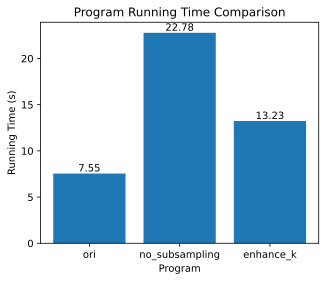

In [9]:
# 设置横坐标和对应的运行时间数据
x = ['ori', 'no_subsampling', 'enhance_k']
y = [7.55, 22.78, 13.23]

d2l.set_figsize((5, 4))
# 绘制柱状图
bars = d2l.plt.bar(x, y)
for rect in bars:
    height = rect.get_height()
    d2l.plt.text(rect.get_x() + rect.get_width() / 2, height,
                 '%.2f' % height, ha='center', va='bottom')
# 添加标题和标签
d2l.plt.title('Program Running Time Comparison')
d2l.plt.xlabel('Program')
d2l.plt.ylabel('Running Time (s)')

# 显示图形
d2l.plt.show()


### 练习14.3.3

本节代码中的哪些其他超参数可能会影响数据加载速度？

**解答：**

&emsp;&emsp;1.min_freq(Vocab里面)

&emsp;&emsp;2.max_window_size

&emsp;&emsp;3.num_works

&emsp;&emsp;4.batch_size

## 14.4 预训练word2vec

### 练习14.4.1

使用训练好的模型，找出其他输入词在语义上相似的词。您能通过调优超参数来改进结果吗？

**解答：**

&emsp;&emsp;可以通过调整超参数来改变词向量的质量。以下是一些常用的超参数：

&emsp;&emsp;1.嵌入维度（embedding dimension）：这是词向量的长度。一般来说，维度越高，模型能够捕捉的语义信息就越多，但是会增加模型的复杂度和训练时间。因此，需要在维度和模型性能之间进行平衡。

&emsp;&emsp;2.上下文窗口大小（context window size）：这是用来定义中心词周围的词语的范围。上下文窗口大小越大，模型能够捕捉到更多的上下文信息，但是也会增加噪声词的数量，使得训练时间增加。

&emsp;&emsp;3.负采样数量（negative sampling count）：这是用来指定负样本的数量。增加负样本数量可以提高模型的鲁棒性，但是也会增加训练时间和计算复杂度。

&emsp;&emsp;4.学习率（learning rate）：这是用来控制每次参数更新的步长。学习率越大，模型的收敛速度越快，但是也会增加训练过程中的不稳定性。

&emsp;&emsp;通过调整这些超参数，可以改进词向量的质量，从而提高找到与输入词在语义上相似的词的准确性。一般来说，我们需要对不同的超参数组合进行实验，选择效果最好的一组超参数。

### 练习14.4.2

当训练语料库很大时，在更新模型参数时，我们经常对当前小批量的*中心词*进行上下文词和噪声词的采样。换言之，同一中心词在不同的训练迭代轮数可以有不同的上下文词或噪声词。这种方法的好处是什么？尝试实现这种训练方法。

**解答：**

&emsp;&emsp;**好处:**

&emsp;&emsp;1.提高训练速度：对于大型语料库，使用全量数据进行训练会导致计算量极大，而采用随机采样的方法可以使训练速度更快。

&emsp;&emsp;2.提高模型泛化能力：使用随机采样可以使模型学习到更多的上下文和噪声，从而可以更好地泛化到未见过的数据中。

&emsp;&emsp;3.减轻过拟合：使用随机采样可以减少模型对某些具体的上下文或噪声的过度拟合，从而提高模型的泛化能力。

&emsp;&emsp;4.改善训练效果：随机采样可以使模型学习到更多的语言结构和规律，从而改善模型的训练效果。

&emsp;&emsp;5.处理长尾词汇：随机采样可以使模型更好地学习到罕见词汇的语义信息，从而提高模型对于长尾词汇的处理能力。

&emsp;&emsp;**实现:**

## 14.5 全局向量的词嵌入（GloVe）

### 练习14.5.1

如果词$w_i$和$w_j$在同一上下文窗口中同时出现，我们如何使用它们在文本序列中的距离来重新设计计算条件概率$p_{ij}$的方法？提示：参见GloVe论文的第4.2节。

**解答：**

&emsp;&emsp;在GloVe论文的第4.2节中，作者讨论了如何利用词wi和wj在同一个上下文窗口中出现的距离来重新设计计算条件概率pij的方法。具体地说，他们使用了一个称为“加权最小二乘”（Weighted Least Squares）的方法来优化模型。

&emsp;&emsp;在这个方法中，作者定义了一个对数线性模型，该模型用来描述两个词在上下文中同时出现的频率与它们在整个语料库中共同出现的频率之间的关系。具体地说，作者使用以下形式的模型：
$$
log({X_{i\,\!j}}) = log({V_i}) + log({V_j}) + b
$$
&emsp;&emsp;其中，Xij表示wi和wj在上下文中同时出现的次数，Vi和Vj分别表示wi和wj在整个语料库中出现的总次数，而b是一个偏置项。

&emsp;&emsp;为了使用词wi和wj在上下文中的距离来重新设计计算条件概率pij的方法，作者将模型修改为以下形式：
$$
f(d_{i\,\!j}) = log({X_{i\,\!j}}) - log({V_i}) - log({V_j})
$$
&emsp;&emsp;其中，dij表示wi和wj在文本序列中的距离，f是一个可调的函数。作者使用了一个函数f，使得f(dij)能够很好地近似于log(dij)。然后，他们使用加权最小二乘法来拟合这个新的模型，以找到最优的函数f和参数b。

&emsp;&emsp;在拟合过程中，作者使用了一个权重函数h(dij)，用于调整每个样本的权重，使得距离更近的样本在拟合中具有更高的权重。最终，他们得到了一个重新设计的模型，可以用来计算两个词之间的条件概率pij，其中词wi和wj在上下文中的距离被考虑在内。

### 练习14.5.2

对于任何一个词，它的中心词偏置和上下文偏置在数学上是等价的吗？为什么？

**解答：**

&emsp;&emsp;在 GloVe 中，中心词偏置和上下文偏置在数学上不是等价的，因为它们分别代表了不同的语言现象。

&emsp;&emsp;中心词偏置是指一个词在所有上下文中出现的频率，而上下文偏置是指所有与一个词一起出现的单词的频率之和。这两个偏置量代表了不同的语言现象，因此在数学上它们是不等价的。

&emsp;&emsp;例如，在一个文本中，词 "the" 可能在各种上下文中都经常出现，因此它的中心词偏置会很高。另一方面，如果一个文本中有很多与 "dog" 相关的单词（如 "cat"、"pet"、"leash" 等），那么 "dog" 的上下文偏置会很高。

&emsp;&emsp;在 GloVe 模型中，中心词偏置和上下文偏置都被用来计算词之间的共现概率，但它们被赋予不同的权重。具体来说，中心词偏置被用来计算一个词在上下文中出现的频率，而上下文偏置被用来计算这个词与其他单词一起出现的频率。这种权重的分配可以让 GloVe 模型更好地捕捉不同词之间的语义关系，从而提高模型的性能。

## 14.6 子词嵌入

### 练习14.6.1

例如，英语中大约有$3\times 10^8$种可能的$6$-元组。子词太多会有什么问题呢？如何解决这个问题？提示:请参阅fastText论文第3.2节末尾。

**解答：**

&emsp;&emsp;在英语中，一个 6 元组的子词数量大约有 3 x 10^8 个，这意味着如果我们使用 6-gram 子词，词汇表的大小将会大大增加，这会导致存储和计算成本的增加，并且会使得模型更加复杂，容易出现过拟合等问题。

&emsp;&emsp;为了解决这个问题，fastText 使用了哈希技术来将子词映射到一个较小的固定大小的哈希表中，从而避免了子词数量的爆炸式增长。具体来说，fastText 将每个子词映射到一个唯一的哈希值，然后使用这些哈希值来表示子词，这样就可以将子词存储在一个固定大小的哈希表中。这种方法可以有效地减少模型的存储和计算成本，并且可以使得模型更加稳定和可靠。

&emsp;&emsp;需要注意的是，使用哈希技术来处理子词可能会导致哈希冲突，即不同的子词可能被映射到相同的哈希值。为了解决这个问题，fastText 使用了一种称为“n-gram buckets”的技术，将具有相同哈希值的子词放置在同一个桶中，从而避免了哈希冲突的问题。

### 练习14.6.2

如何在连续词袋模型的基础上设计一个子词嵌入模型？

**解答：**

### 练习14.6.3

要获得大小为$m$的词表，当初始符号词表大小为$n$时，需要多少合并操作？

**解答：**

&emsp;&emsp;在 fastText 中，用于构建词表的初始符号词表大小为 n，要获得大小为 m 的最终词表，最多需要进行`m-n`次合并操作。

&emsp;&emsp;这是由于每次合并操作都会将两个子词合并为一个新的子词，在fastText中，词是由子词加和代表的，原来的词表为n，若在合并次数少于m-n的情况下，已经得到了能够表达m个词的所有子词，则会会提前终止合并，所以合并次数是会小于等于词表差值。

### 练习14.6.4

如何扩展字节对编码的思想来提取短语？

**解答：**

&emsp;&emsp;1.对语料库中的所有单词应用字节对编码，将每个单词拆分为多个子词。

&emsp;&emsp;2.遍历语料库中所有的单词，将相邻的子词组合成新的短语，并统计每个短语的出现次数。

&emsp;&emsp;3.将出现次数最多的短语作为新的合并符号，并将其添加到词表中。然后，将语料库中所有的短语中包含该符号的部分替换为该符号，以生成新的语料库。

&emsp;&emsp;4.重复步骤2和3，直到达到所需的短语数目或无法生成新的短语为止。

&emsp;&emsp;5.通过这种方法，可以从语料库中提取出多个短语，这些短语可以用于构建更准确的文本表示。此外，这种方法还可以提高模型的泛化能力，因为模型可以更好地捕捉短语级别的语义信息。

## 14.7 词的相似度和类比任务

### 练习14.7.1

使用`TokenEmbedding('wiki.en')`测试fastText结果。

**解答：**

&emsp;&emsp;**将源代码改成下面的'wiki.en'即可：**

In [38]:
glove_6b50d = d2l.TokenEmbedding('wiki.en')

### 练习14.7.2

当词表非常大时，我们怎样才能更快地找到相似的词或完成一个词的类比呢？

**解答：**

&emsp;&emsp;1.基于向量空间模型的方法：将每个单词表示为一个向量，通过计算向量之间的距离或相似度来寻找相似词或完成词类比。这种方法可以通过使用近似最近邻算法（如ANN）来加速计算。

&emsp;&emsp;2.基于哈希表的方法：将每个单词映射到哈希表中的一个位置，然后通过比较哈希表中的位置来判断单词之间的相似性。这种方法可以通过使用一些高效的哈希函数和哈希表的优化技巧来提高速度。

&emsp;&emsp;3.基于子词信息的方法：将单词分解为多个子词，并使用这些子词的向量来表示单词，从而可以更好地处理未登录词和词形变化。这种方法可以通过使用快速文本搜索算法（如Trie）来加速计算。

&emsp;&emsp;4.基于近似算法的方法：使用一些近似算法来计算词向量之间的相似度，如局部敏感哈希（LSH）、随机投影和低秩近似等。这些算法可以大大减少计算时间和空间复杂度。

&emsp;&emsp;总的来说，选择适合任务的算法和技术可以在大词表下提高相似词寻找和词类比的速度和准确度。

## 14.8 来自Transformer的双向编码器表示（BERT）

### 练习14.8.1

为什么BERT成功了？

**解答：**

&emsp;&emsp;同期的模型ELMo对上下文进行双向编码，解决了一词多意等问题，但是智能使用特定于某个任务的架构，不能进行finetune；同期的GPT是任务无关性的，但是仅能从做导游对上下文进行编码。

&emsp;&emsp;BERT结合了二者的优势，对上下文进行双向编码，且任务无关，对大多数nlp任务只需要对架构进行finetune即可。故BERT在同时期使用效果更好！

### 练习14.8.2

在所有其他条件相同的情况下，掩蔽语言模型比从左到右的语言模型需要更多或更少的预训练步骤来收敛吗？为什么？

**解答：**

&emsp;&emsp;在其他条件相同的情况下，掩蔽语言模型需要更多的预训练步骤来收敛。这是因为掩蔽语言模型需要预测缺失的'mask'词汇，需要更高的上下文理解能力和更强的推理能力。而从左到右的语言模型只需要预测下一个词汇，相对而言更简单。
  
&emsp;&emsp;举个具体的例子：在BERT为提高上下文理解能力与推理能力所作的掩敝语言模型mlm中，选择15%的词元作为遮盖词元，且为了使后续不同下游任务能够微调，又进行了80%的时间将原始词元替换为mask；10%的时间设置为原所有文本中的随机词元；10%的时间保持原来的词元不变。上述操作增加了模型的复杂程度，所以迭代步数要更多。

### 练习14.8.3

在BERT的原始实现中，`BERTEncoder`中的位置前馈网络（通过`d2l.EncoderBlock`）和`MaskLM`中的全连接层都使用高斯误差线性单元（Gaussian error linear unit，GELU）作为激活函数。研究GELU与ReLU之间的差异。

**解答：**

&emsp;&emsp;GELU是一种激活函数，与ReLU相比，它的主要差异在于它的形状更加平滑。ReLU在输入为负数时输出为0，而GELU在输入为负数时输出一个小的非零值，这使得GELU更加平滑。此外，GELU还具有一些其他的优势，例如在处理较大的数据集时具有更好的性能，以及对于一些复杂的神经网络模型，GELU能够提供更好的训练效果。总体来说，GELU是一种更加灵活和高效的激活函数，可以在许多不同的应用场景中发挥作用。

### 练习14.9.1

为简单起见，句号用作拆分句子的唯一分隔符。尝试其他的句子拆分技术，比如Spacy和NLTK。以NLTK为例，需要先安装NLTK：`pip install nltk`。在代码中先`import nltk`。然后下载Punkt语句词元分析器：`nltk.download('punkt')`。要拆分句子，比如`sentences = 'This is great ! Why not ?'`，调用`nltk.tokenize.sent_tokenize(sentences)`将返回两个句子字符串的列表：`['This is great !', 'Why not ?']`。

**解答：**

&emsp;&emsp;先把shuffle去了好直观对比

In [1]:
from d2l import torch as d2l
import torch
import os

def _read_wiki2(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # ⼤写字⺟转换为⼩写字⺟
    paragraphs = [line.strip().lower().split(' . ')
                    for line in lines if len(line.split(' . ')) >= 2]
#     random.shuffle(paragraphs)
    return paragraphs

data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
para_ori = _read_wiki2(data_dir)

&emsp;&emsp;可见原本是通过' . ' 来分割的，注意必须是dot两边都有一个空格才能分割

In [2]:
len(para_ori[2]), para_ori[2]

(5,
 ['it met with positive sales in japan , and was praised by both japanese and western critics',
  'after release , it received downloadable content , along with an expanded edition in november of that year',
  'it was also adapted into manga and an original video animation series',
  "due to low sales of valkyria chronicles ii , valkyria chronicles iii was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014",
  'media.vision would return to the franchise with the development of valkyria : azure revolution for the playstation 4 .'])

In [3]:
!pip install nltk

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 1.5/1.5 MB 744.3 kB/s eta 0:00:00


&emsp;&emsp;这个if判断条件是为了消去一些空字符行用的。

In [6]:
import nltk
nltk.download('punkt')

def _read_wiki_nltk(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # ⼤写字⺟转换为⼩写字⺟
    paragraphs = [nltk.tokenize.sent_tokenize(line.strip().lower())
                    for line in lines if len(line.split(' . ')) >= 2]
#     random.shuffle(paragraphs)
    return paragraphs

para_nltk = _read_wiki_nltk(data_dir)
len(para_nltk[2]), para_nltk[2]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(5,
 ['it met with positive sales in japan , and was praised by both japanese and western critics .',
  'after release , it received downloadable content , along with an expanded edition in november of that year .',
  'it was also adapted into manga and an original video animation series .',
  "due to low sales of valkyria chronicles ii , valkyria chronicles iii was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 .",
  'media.vision would return to the franchise with the development of valkyria : azure revolution for the playstation 4 .'])

In [7]:
# demo = nltk.tokenize.sent_tokenize(para_nltk[0])
# len(demo), demo

&emsp;&emsp;可见nltk的作用体现了。区分二者可以人为再构造几个不同的标点符号：

In [8]:
lined = 'This is great ! Why not ? ah!a'
nltk.tokenize.sent_tokenize(lined), lined.strip().lower().split(' . ')

(['This is great !', 'Why not ?', 'ah!a'], ['this is great ! why not ? ah!a'])

### 练习14.9.2

如果我们不过滤出一些不常见的词元，词量会有多大？

**解答：**

&emsp;&emsp;将class _WikiTextDataset中的vocab中的min_freq=0即可，输出len(vocab)=28886

## 14.10 预训练BERT

### 练习14.10.1

在实验中，我们可以看到遮蔽语言模型损失明显高于下一句预测损失。为什么？

**解答：**

&emsp;&emsp;掩蔽语言模型是一种预测中间掩盖掉的词的任务，相当于完形填空：它要求模型在给定上下文的一些词的情况下，预测中间扣除的词是什么。相比之下，下一句预测任务是要求模型在给定一句话的情况下，预测下一句话是什么。

&emsp;&emsp;由此可知，掩蔽语言模型需要预测多个位置的单词，而下一句预测任务只需要预测一整句话，因此掩蔽语言模型需要更多的预测任务，模型需要更好地理解句子中的语言结构和上下文关系，才能准确地预测每个位置的单词，因此其损失会更大。

&emsp;&emsp;**具体到本节中的例子而言:** 对下一句预测仅仅抽取了原句子中'cls'词元对应的hiddens信息，送入mlp的输入为(bs,1,h);而在mlm中，送入mlp的是(bs,Tmask,h),输出相应的hat值(bs,Tmask,len(vocab)),其中Tmask就是每个句子中需要预测的词元数量，书上表示的是10(模型更加复杂。

### 练习14.10.2

将BERT输入序列的最大长度设置为512（与原始BERT模型相同）。使用原始BERT模型的配置，如$\text{BERT}_{\text{LARGE}}$。运行此部分时是否遇到错误？为什么？

**解答：**

&emsp;&emsp;笔者使用的4块2080ti，更改后会报OutOfMemoryError错误，是因为一次性读取的数据超出内存。